<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [10]</a>'.</span>

In [1]:
# Parameters
fraction_training = 1.0
n_contributions = 21
n_punishments = 31
n_cross_val = None
n_player = 4
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"
output_path = "../../data/training/ah_10"
model_name = "graph"
shuffle_features = ["prev_punishments", "prev_contributions", "prev_common_good"]
labels = {}
model_args = {
    "hidden_size": 5,
    "add_rnn": True,
    "add_edge_model": True,
    "add_global_model": False,
    "x_encoding": [
        {"name": "prev_contributions", "n_levels": 21, "encoding": "numeric"},
        {"name": "prev_punishments", "n_levels": 31, "encoding": "numeric"},
    ],
    "u_encoding": [
        {"name": "round_number", "n_levels": 16, "encoding": "numeric"},
        {"name": "prev_common_good", "norm": 128, "etype": "float"},
    ],
}
optimizer_args = {"lr": 0.001, "weight_decay": 1e-05}
train_args = {"epochs": 5000, "batch_size": 10, "clamp_grad": 1, "eval_period": 10}
device = "cpu"


In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import torch as th
from aimanager.generic.data import create_syn_data, create_torch_data, get_cross_validations
from aimanager.artificial_humans import AH_MODELS
from aimanager.artificial_humans.evaluation import Evaluator
from aimanager.utils.array_to_df import using_multiindex
from aimanager.generic.graph_encode import create_fully_connected
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

output_path = os.path.join(output_path, 'data')

/Users/levinbrinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv(data_file)

data, default_values = create_torch_data(df)
syn_data = create_syn_data(n_contribution=21, n_punishment=31, default_values=default_values)

In [4]:
th_device = th.device(device)

metrics = []
confusion_matrix = []
syn_pred = []
ev = Evaluator()

th_device = th.device(device)

syn_index = ['prev_punishments', 'prev_contributions']
edge_index = create_fully_connected(n_player)


def shuffle_feature(data, feature_name):
    data = {**data}
    data[feature_name] = data[feature_name][th.randperm(len(data[feature_name]))]
    return data

for i, (train_data, test_data) in enumerate(get_cross_validations(data, n_cross_val, fraction_training)):
    model = AH_MODELS[model_name](
        n_contributions=n_contributions, n_punishments=n_punishments, default_values=default_values,
        **model_args).to(th_device)

    train_data_ = model.encode(train_data, mask=True, edge_index=edge_index)
    if test_data is not None:
        test_data_ = model.encode(test_data, mask=True, edge_index=edge_index)
    syn_data_ = model.encode(syn_data, mask=False, y_encode=False, info_columns=syn_index, edge_index=edge_index)

    syn_df = using_multiindex(
        Batch.from_data_list(syn_data_)['info'].detach().cpu().numpy(), ['idx', 'round_number'], syn_index)

    optimizer = th.optim.Adam(model.parameters(), **optimizer_args)
    loss_fn = th.nn.CrossEntropyLoss(reduction='none')
    sum_loss = 0
    n_steps = 0

    for e in range(train_args['epochs']):
        ev.set_labels(cv_split=i, epoch=e)
        model.train()
        for j, batch_data in enumerate(iter(DataLoader(train_data_, shuffle=True, batch_size=train_args['batch_size']))):
            optimizer.zero_grad()
            py = model(batch_data).flatten(end_dim=-2)
            y_true = batch_data['y_enc'].flatten(end_dim=-2)
            mask = batch_data['mask'].flatten()
            loss = loss_fn(py, y_true)
            loss = (loss * mask).sum() / mask.sum()

            loss.backward()

            if train_args['clamp_grad']:
                for param in model.parameters():
                    param.grad.data.clamp_(-train_args['clamp_grad'], train_args['clamp_grad'])
            optimizer.step()
            sum_loss += loss.item()
            n_steps +=1
        
        last_epoch = e == (train_args['epochs'] - 1)

        if (e % train_args['eval_period'] == 0) or last_epoch:
            avg_loss = sum_loss/n_steps
            print(f'CV {i} | Epoch {e} | Loss {avg_loss}')
            ev.add_loss(avg_loss)

            ev.eval_set(model, train_data_, calc_confusion=last_epoch, set='train')
            if test_data is not None:
                ev.eval_set(model, test_data_, calc_confusion=last_epoch, set='test')
                for sf in shuffle_features:
                    shuffled_data = shuffle_feature(test_data, sf)
                    shuffled_data = model.encode(shuffled_data, mask=True, edge_index=edge_index)
                    ev.eval_set(model, shuffled_data, calc_confusion=False, set='test', shuffle_feature=sf)
            sum_loss = 0
            n_steps = 0
    ev.eval_syn(model, syn_data_, syn_df)

ev.save(output_path, labels)
model_path = os.path.join(output_path, 'model.pt')
model.save(model_path)

CV 0 | Epoch 0 | Loss 3.2683498007910594


CV 0 | Epoch 10 | Loss 2.9591211676597595


CV 0 | Epoch 20 | Loss 2.522594668184008


CV 0 | Epoch 30 | Loss 2.3599366213594166


CV 0 | Epoch 40 | Loss 2.24746624316488


CV 0 | Epoch 50 | Loss 2.185321853842054


CV 0 | Epoch 60 | Loss 2.150825286763055


CV 0 | Epoch 70 | Loss 2.123729534660067


CV 0 | Epoch 80 | Loss 2.103957618985857


CV 0 | Epoch 90 | Loss 2.090732694523675


CV 0 | Epoch 100 | Loss 2.0758964027677265


CV 0 | Epoch 110 | Loss 2.0548614152840208


CV 0 | Epoch 120 | Loss 2.0475962945393156


CV 0 | Epoch 130 | Loss 2.034674254485539


CV 0 | Epoch 140 | Loss 2.024224099942616


CV 0 | Epoch 150 | Loss 2.0042228741305217


CV 0 | Epoch 160 | Loss 1.9867639320237296


CV 0 | Epoch 170 | Loss 1.9961127817630768


CV 0 | Epoch 180 | Loss 1.9764261169092996


CV 0 | Epoch 190 | Loss 1.958639930827277


CV 0 | Epoch 200 | Loss 1.9488258864198411


CV 0 | Epoch 210 | Loss 1.9464553781918117


CV 0 | Epoch 220 | Loss 1.9360749534198216


CV 0 | Epoch 230 | Loss 1.923813739844731


CV 0 | Epoch 240 | Loss 1.907954844406673


CV 0 | Epoch 250 | Loss 1.8936906227043697


CV 0 | Epoch 260 | Loss 1.9020198753901891


CV 0 | Epoch 270 | Loss 1.8983768905912126


CV 0 | Epoch 280 | Loss 1.8937774121761322


CV 0 | Epoch 290 | Loss 1.8894280706133162


CV 0 | Epoch 300 | Loss 1.8814919923033033


CV 0 | Epoch 310 | Loss 1.8818972996303014


CV 0 | Epoch 320 | Loss 1.8688531952244896


CV 0 | Epoch 330 | Loss 1.8702852385384696


CV 0 | Epoch 340 | Loss 1.8618735841342382


CV 0 | Epoch 350 | Loss 1.8712656940732684


CV 0 | Epoch 360 | Loss 1.858476117679051


CV 0 | Epoch 370 | Loss 1.8586055559771402


CV 0 | Epoch 380 | Loss 1.8582797842366354


CV 0 | Epoch 390 | Loss 1.8551943838596343


CV 0 | Epoch 400 | Loss 1.8528495218072618


CV 0 | Epoch 410 | Loss 1.8475582012108394


CV 0 | Epoch 420 | Loss 1.8414348917348045


CV 0 | Epoch 430 | Loss 1.8473262872014726


CV 0 | Epoch 440 | Loss 1.8454497754573822


CV 0 | Epoch 450 | Loss 1.8412843201841627


CV 0 | Epoch 460 | Loss 1.8347974734646932


CV 0 | Epoch 470 | Loss 1.8329035358769552


CV 0 | Epoch 480 | Loss 1.8421903678349085


CV 0 | Epoch 490 | Loss 1.8342347179140364


CV 0 | Epoch 500 | Loss 1.8348151317664556


CV 0 | Epoch 510 | Loss 1.8348020885671887


CV 0 | Epoch 520 | Loss 1.8360607283455985


CV 0 | Epoch 530 | Loss 1.823885919366564


CV 0 | Epoch 540 | Loss 1.8343170148985726


CV 0 | Epoch 550 | Loss 1.828584510087967


CV 0 | Epoch 560 | Loss 1.8337074296815055


CV 0 | Epoch 570 | Loss 1.821830714600427


CV 0 | Epoch 580 | Loss 1.8352097758225032


CV 0 | Epoch 590 | Loss 1.825801397221429


CV 0 | Epoch 600 | Loss 1.8339688607624598


CV 0 | Epoch 610 | Loss 1.8225559328283583


CV 0 | Epoch 620 | Loss 1.8251595973968506


CV 0 | Epoch 630 | Loss 1.8222235126154764


CV 0 | Epoch 640 | Loss 1.8193756239754812


CV 0 | Epoch 650 | Loss 1.8225484124251774


CV 0 | Epoch 660 | Loss 1.8167427395071303


CV 0 | Epoch 670 | Loss 1.821538406610489


CV 0 | Epoch 680 | Loss 1.8196587562561035


CV 0 | Epoch 690 | Loss 1.8245664698737007


CV 0 | Epoch 700 | Loss 1.8230485149792262


CV 0 | Epoch 710 | Loss 1.8198745701994214


CV 0 | Epoch 720 | Loss 1.8276294069630759


CV 0 | Epoch 730 | Loss 1.8194791615009307


CV 0 | Epoch 740 | Loss 1.8076751359871455


CV 0 | Epoch 750 | Loss 1.8160309289182937


CV 0 | Epoch 760 | Loss 1.806024335537638


CV 0 | Epoch 770 | Loss 1.818436953851155


CV 0 | Epoch 780 | Loss 1.8208720667021616


CV 0 | Epoch 790 | Loss 1.8124591742243086


CV 0 | Epoch 800 | Loss 1.8125827252864837


CV 0 | Epoch 810 | Loss 1.8126920640468598


CV 0 | Epoch 820 | Loss 1.8129371430192676


CV 0 | Epoch 830 | Loss 1.8046130159071514


CV 0 | Epoch 840 | Loss 1.8088642026696886


CV 0 | Epoch 850 | Loss 1.8187882363796235


CV 0 | Epoch 860 | Loss 1.8106109355177198


CV 0 | Epoch 870 | Loss 1.805572727748326


CV 0 | Epoch 880 | Loss 1.8131535053253174


CV 0 | Epoch 890 | Loss 1.8134410687855311


CV 0 | Epoch 900 | Loss 1.8106140877519334


CV 0 | Epoch 910 | Loss 1.8098501818520683


CV 0 | Epoch 920 | Loss 1.8110152057238988


CV 0 | Epoch 930 | Loss 1.819604308264596


CV 0 | Epoch 940 | Loss 1.8050240533692496


CV 0 | Epoch 950 | Loss 1.8112665270056043


CV 0 | Epoch 960 | Loss 1.8103801829474313


CV 0 | Epoch 970 | Loss 1.8064787200519017


CV 0 | Epoch 980 | Loss 1.8105688282421657


CV 0 | Epoch 990 | Loss 1.8056281319686345


CV 0 | Epoch 1000 | Loss 1.8071017827306475


CV 0 | Epoch 1010 | Loss 1.809994009562901


CV 0 | Epoch 1020 | Loss 1.8074856689998082


CV 0 | Epoch 1030 | Loss 1.8007275291851588


CV 0 | Epoch 1040 | Loss 1.8038382955959864


CV 0 | Epoch 1050 | Loss 1.8075494868414743


CV 0 | Epoch 1060 | Loss 1.8050539229597364


CV 0 | Epoch 1070 | Loss 1.8037607499531336


CV 0 | Epoch 1080 | Loss 1.7991896084376744


CV 0 | Epoch 1090 | Loss 1.8009180034909928


CV 0 | Epoch 1100 | Loss 1.8014803741659438


CV 0 | Epoch 1110 | Loss 1.807359949180058


CV 0 | Epoch 1120 | Loss 1.8050737517220634


CV 0 | Epoch 1130 | Loss 1.8070630716426033


CV 0 | Epoch 1140 | Loss 1.8025807857513427


CV 0 | Epoch 1150 | Loss 1.8040349330220904


CV 0 | Epoch 1160 | Loss 1.800099903345108


CV 0 | Epoch 1170 | Loss 1.8007158185754504


CV 0 | Epoch 1180 | Loss 1.8044775920254843


CV 0 | Epoch 1190 | Loss 1.800229834658759


CV 0 | Epoch 1200 | Loss 1.7974655772958483


CV 0 | Epoch 1210 | Loss 1.801731319938387


CV 0 | Epoch 1220 | Loss 1.7901218903916223


CV 0 | Epoch 1230 | Loss 1.7934478955609459


CV 0 | Epoch 1240 | Loss 1.7938916427748544


CV 0 | Epoch 1250 | Loss 1.8016221616949355


CV 0 | Epoch 1260 | Loss 1.8020177330289568


CV 0 | Epoch 1270 | Loss 1.800253507069179


CV 0 | Epoch 1280 | Loss 1.7935257996831622


CV 0 | Epoch 1290 | Loss 1.7930716191019331


CV 0 | Epoch 1300 | Loss 1.7937877195222036


CV 0 | Epoch 1310 | Loss 1.7934160147394453


CV 0 | Epoch 1320 | Loss 1.7966589144298009


CV 0 | Epoch 1330 | Loss 1.7958029304231917


CV 0 | Epoch 1340 | Loss 1.7964258474963053


CV 0 | Epoch 1350 | Loss 1.7938882981027875


CV 0 | Epoch 1360 | Loss 1.7968842438289097


CV 0 | Epoch 1370 | Loss 1.789480915239879


CV 0 | Epoch 1380 | Loss 1.7918391627924783


CV 0 | Epoch 1390 | Loss 1.7917299687862396


CV 0 | Epoch 1400 | Loss 1.794719810145242


CV 0 | Epoch 1410 | Loss 1.791582212277821


CV 0 | Epoch 1420 | Loss 1.7870769969054632


CV 0 | Epoch 1430 | Loss 1.7907279295580727


CV 0 | Epoch 1440 | Loss 1.7893593404974257


CV 0 | Epoch 1450 | Loss 1.7927946993282864


CV 0 | Epoch 1460 | Loss 1.7890416605131967


CV 0 | Epoch 1470 | Loss 1.7936694928577968


CV 0 | Epoch 1480 | Loss 1.7866954922676086


CV 0 | Epoch 1490 | Loss 1.7924542052405221


CV 0 | Epoch 1500 | Loss 1.7902201082025255


CV 0 | Epoch 1510 | Loss 1.7811635545321873


CV 0 | Epoch 1520 | Loss 1.7903798460960387


CV 0 | Epoch 1530 | Loss 1.7914277476923806


CV 0 | Epoch 1540 | Loss 1.7926688075065613


CV 0 | Epoch 1550 | Loss 1.7887253650597164


CV 0 | Epoch 1560 | Loss 1.7858514513288226


CV 0 | Epoch 1570 | Loss 1.7880685363497053


CV 0 | Epoch 1580 | Loss 1.7941803216934205


CV 0 | Epoch 1590 | Loss 1.785120228784425


CV 0 | Epoch 1600 | Loss 1.7813359107289994


CV 0 | Epoch 1610 | Loss 1.7802360679422107


CV 0 | Epoch 1620 | Loss 1.7823905169963836


CV 0 | Epoch 1630 | Loss 1.7858048975467682


CV 0 | Epoch 1640 | Loss 1.78280154807227


CV 0 | Epoch 1650 | Loss 1.783366142000471


CV 0 | Epoch 1660 | Loss 1.781920622076307


CV 0 | Epoch 1670 | Loss 1.7791864054543631


CV 0 | Epoch 1680 | Loss 1.7805781475135258


CV 0 | Epoch 1690 | Loss 1.7742273824555532


CV 0 | Epoch 1700 | Loss 1.7846095289502826


CV 0 | Epoch 1710 | Loss 1.783719265460968


CV 0 | Epoch 1720 | Loss 1.7838788381644657


CV 0 | Epoch 1730 | Loss 1.7846233350890024


CV 0 | Epoch 1740 | Loss 1.7711038146700178


CV 0 | Epoch 1750 | Loss 1.7785644565309797


CV 0 | Epoch 1760 | Loss 1.7700807239328111


CV 0 | Epoch 1770 | Loss 1.7772454985550472


CV 0 | Epoch 1780 | Loss 1.7760387565408433


CV 0 | Epoch 1790 | Loss 1.7767968169280461


CV 0 | Epoch 1800 | Loss 1.7691582867077418


CV 0 | Epoch 1810 | Loss 1.7709009434495653


CV 0 | Epoch 1820 | Loss 1.7808532612664358


CV 0 | Epoch 1830 | Loss 1.7775914686066763


CV 0 | Epoch 1840 | Loss 1.7754510862486703


CV 0 | Epoch 1850 | Loss 1.7700003010886056


CV 0 | Epoch 1860 | Loss 1.7689086965152196


CV 0 | Epoch 1870 | Loss 1.78092731152262


CV 0 | Epoch 1880 | Loss 1.772158613375255


CV 0 | Epoch 1890 | Loss 1.7694801713739123


CV 0 | Epoch 1900 | Loss 1.7792309394904546


CV 0 | Epoch 1910 | Loss 1.7681602111884527


CV 0 | Epoch 1920 | Loss 1.7618575411183492


CV 0 | Epoch 1930 | Loss 1.7708323776721955


CV 0 | Epoch 1940 | Loss 1.7683584128107344


CV 0 | Epoch 1950 | Loss 1.7758809694222042


CV 0 | Epoch 1960 | Loss 1.764453295298985


CV 0 | Epoch 1970 | Loss 1.7723763840539115


CV 0 | Epoch 1980 | Loss 1.7661895556109293


CV 0 | Epoch 1990 | Loss 1.7600194249834333


CV 0 | Epoch 2000 | Loss 1.7714534291199275


CV 0 | Epoch 2010 | Loss 1.7694890209606715


CV 0 | Epoch 2020 | Loss 1.7661816239356996


CV 0 | Epoch 2030 | Loss 1.7628381294863564


CV 0 | Epoch 2040 | Loss 1.772543444803783


CV 0 | Epoch 2050 | Loss 1.7743202839578902


CV 0 | Epoch 2060 | Loss 1.7670738914183208


CV 0 | Epoch 2070 | Loss 1.7612608049597058


CV 0 | Epoch 2080 | Loss 1.7630383606467928


CV 0 | Epoch 2090 | Loss 1.7671514741012029


CV 0 | Epoch 2100 | Loss 1.76327509028571


CV 0 | Epoch 2110 | Loss 1.7600839138031006


CV 0 | Epoch 2120 | Loss 1.7678058181490217


CV 0 | Epoch 2130 | Loss 1.7636904111930303


CV 0 | Epoch 2140 | Loss 1.7635780683585576


CV 0 | Epoch 2150 | Loss 1.764046038900103


CV 0 | Epoch 2160 | Loss 1.7658027563776288


CV 0 | Epoch 2170 | Loss 1.7613290331193379


CV 0 | Epoch 2180 | Loss 1.7686153641768865


CV 0 | Epoch 2190 | Loss 1.7598290145397186


CV 0 | Epoch 2200 | Loss 1.7701204563890185


CV 0 | Epoch 2210 | Loss 1.757337154660906


CV 0 | Epoch 2220 | Loss 1.7622396511690956


CV 0 | Epoch 2230 | Loss 1.755145229612078


CV 0 | Epoch 2240 | Loss 1.7593773118087224


CV 0 | Epoch 2250 | Loss 1.758801394701004


CV 0 | Epoch 2260 | Loss 1.754898508957454


CV 0 | Epoch 2270 | Loss 1.7535969538348062


CV 0 | Epoch 2280 | Loss 1.7526277099336898


CV 0 | Epoch 2290 | Loss 1.758255489383425


CV 0 | Epoch 2300 | Loss 1.7539477246148245


CV 0 | Epoch 2310 | Loss 1.7525143555232456


CV 0 | Epoch 2320 | Loss 1.7553222268819808


CV 0 | Epoch 2330 | Loss 1.7575277592454637


CV 0 | Epoch 2340 | Loss 1.7564569013459341


CV 0 | Epoch 2350 | Loss 1.7602684821401324


CV 0 | Epoch 2360 | Loss 1.7586296600954874


CV 0 | Epoch 2370 | Loss 1.7541971717561995


CV 0 | Epoch 2380 | Loss 1.7627725882189615


CV 0 | Epoch 2390 | Loss 1.7544471672603061


CV 0 | Epoch 2400 | Loss 1.7511713334492274


CV 0 | Epoch 2410 | Loss 1.7558845128331866


CV 0 | Epoch 2420 | Loss 1.752211606502533


CV 0 | Epoch 2430 | Loss 1.7474643213408334


CV 0 | Epoch 2440 | Loss 1.757361305611474


CV 0 | Epoch 2450 | Loss 1.7564102360180447


CV 0 | Epoch 2460 | Loss 1.7607295743056706


CV 0 | Epoch 2470 | Loss 1.7571346368108476


CV 0 | Epoch 2480 | Loss 1.74818987931524


CV 0 | Epoch 2490 | Loss 1.755478196484702


CV 0 | Epoch 2500 | Loss 1.7518323762076242


CV 0 | Epoch 2510 | Loss 1.7487728757517678


CV 0 | Epoch 2520 | Loss 1.751367348432541


CV 0 | Epoch 2530 | Loss 1.750508175577436


CV 0 | Epoch 2540 | Loss 1.757229335818972


CV 0 | Epoch 2550 | Loss 1.7578205193792071


CV 0 | Epoch 2560 | Loss 1.7544683141367776


CV 0 | Epoch 2570 | Loss 1.7503794142178126


CV 0 | Epoch 2580 | Loss 1.7458544330937522


CV 0 | Epoch 2590 | Loss 1.744313771384103


CV 0 | Epoch 2600 | Loss 1.742310812643596


CV 0 | Epoch 2610 | Loss 1.751333191565105


CV 0 | Epoch 2620 | Loss 1.7508267079080855


CV 0 | Epoch 2630 | Loss 1.7496701513017927


CV 0 | Epoch 2640 | Loss 1.751717942101615


CV 0 | Epoch 2650 | Loss 1.747229883500508


CV 0 | Epoch 2660 | Loss 1.7432219326496123


CV 0 | Epoch 2670 | Loss 1.7437746699367251


CV 0 | Epoch 2680 | Loss 1.747449152810233


CV 0 | Epoch 2690 | Loss 1.7437842071056366


CV 0 | Epoch 2700 | Loss 1.747790333202907


CV 0 | Epoch 2710 | Loss 1.750876465865544


CV 0 | Epoch 2720 | Loss 1.75344220995903


CV 0 | Epoch 2730 | Loss 1.7474234470299312


CV 0 | Epoch 2740 | Loss 1.7468959250620433


CV 0 | Epoch 2750 | Loss 1.7469253633703505


CV 0 | Epoch 2760 | Loss 1.7443616424288069


CV 0 | Epoch 2770 | Loss 1.743093260696956


CV 0 | Epoch 2780 | Loss 1.7459705242088863


CV 0 | Epoch 2790 | Loss 1.7446899967534202


CV 0 | Epoch 2800 | Loss 1.7443543314933776


CV 0 | Epoch 2810 | Loss 1.7452344698565347


CV 0 | Epoch 2820 | Loss 1.7424346446990966


CV 0 | Epoch 2830 | Loss 1.7491887739726475


CV 0 | Epoch 2840 | Loss 1.7453509867191315


CV 0 | Epoch 2850 | Loss 1.746430586065565


CV 0 | Epoch 2860 | Loss 1.7419930441038949


CV 0 | Epoch 2870 | Loss 1.743185225554875


CV 0 | Epoch 2880 | Loss 1.7443173280784061


CV 0 | Epoch 2890 | Loss 1.7416547783783505


CV 0 | Epoch 2900 | Loss 1.7441360890865325


CV 0 | Epoch 2910 | Loss 1.737944693650518


CV 0 | Epoch 2920 | Loss 1.7433464416435787


CV 0 | Epoch 2930 | Loss 1.7509510985442571


CV 0 | Epoch 2940 | Loss 1.7454869857856206


CV 0 | Epoch 2950 | Loss 1.7502058267593383


CV 0 | Epoch 2960 | Loss 1.7404417774506977


CV 0 | Epoch 2970 | Loss 1.7479081341198512


CV 0 | Epoch 2980 | Loss 1.7539132399218422


CV 0 | Epoch 2990 | Loss 1.7447482245309012


CV 0 | Epoch 3000 | Loss 1.7486996625150952


CV 0 | Epoch 3010 | Loss 1.7396822094917297


CV 0 | Epoch 3020 | Loss 1.7371357687882014


CV 0 | Epoch 3030 | Loss 1.7408875431333268


CV 0 | Epoch 3040 | Loss 1.7487410928521838


CV 0 | Epoch 3050 | Loss 1.7445851402623314


CV 0 | Epoch 3060 | Loss 1.7418165172849382


CV 0 | Epoch 3070 | Loss 1.7330982651029314


CV 0 | Epoch 3080 | Loss 1.748662891132491


CV 0 | Epoch 3090 | Loss 1.743147896868842


CV 0 | Epoch 3100 | Loss 1.7474597351891654


CV 0 | Epoch 3110 | Loss 1.7382897325924465


CV 0 | Epoch 3120 | Loss 1.7359579878193991


CV 0 | Epoch 3130 | Loss 1.7340002272810255


CV 0 | Epoch 3140 | Loss 1.7359505278723582


CV 0 | Epoch 3150 | Loss 1.7398947732789176


CV 0 | Epoch 3160 | Loss 1.7433109087603433


CV 0 | Epoch 3170 | Loss 1.733223445074899


CV 0 | Epoch 3180 | Loss 1.7429462288107191


CV 0 | Epoch 3190 | Loss 1.7440382225172861


CV 0 | Epoch 3200 | Loss 1.7434240528515408


CV 0 | Epoch 3210 | Loss 1.7401024154254368


CV 0 | Epoch 3220 | Loss 1.7414199130875723


CV 0 | Epoch 3230 | Loss 1.7405240505933761


CV 0 | Epoch 3240 | Loss 1.7423450589179992


CV 0 | Epoch 3250 | Loss 1.7449247343199594


CV 0 | Epoch 3260 | Loss 1.7440953476088388


CV 0 | Epoch 3270 | Loss 1.7380769959517888


CV 0 | Epoch 3280 | Loss 1.7412626598562513


CV 0 | Epoch 3290 | Loss 1.7351865214960915


CV 0 | Epoch 3300 | Loss 1.7357918790408544


CV 0 | Epoch 3310 | Loss 1.739745467049735


CV 0 | Epoch 3320 | Loss 1.7426018817084177


CV 0 | Epoch 3330 | Loss 1.73231144121715


CV 0 | Epoch 3340 | Loss 1.7323628178664616


CV 0 | Epoch 3350 | Loss 1.7349796601704188


CV 0 | Epoch 3360 | Loss 1.7312486861433303


CV 0 | Epoch 3370 | Loss 1.7408958315849303


CV 0 | Epoch 3380 | Loss 1.7389709949493408


CV 0 | Epoch 3390 | Loss 1.737162047624588


CV 0 | Epoch 3400 | Loss 1.7381140342780521


CV 0 | Epoch 3410 | Loss 1.735022234916687


CV 0 | Epoch 3420 | Loss 1.7389750736100333


CV 0 | Epoch 3430 | Loss 1.7336748123168946


CV 0 | Epoch 3440 | Loss 1.739082957165582


CV 0 | Epoch 3450 | Loss 1.7317442378827503


CV 0 | Epoch 3460 | Loss 1.741047079222543


CV 0 | Epoch 3470 | Loss 1.73157850589071


CV 0 | Epoch 3480 | Loss 1.7423737032072886


CV 0 | Epoch 3490 | Loss 1.7413837603160314


CV 0 | Epoch 3500 | Loss 1.730951264500618


CV 0 | Epoch 3510 | Loss 1.7366877802780696


CV 0 | Epoch 3520 | Loss 1.7397307557719095


CV 0 | Epoch 3530 | Loss 1.7370819543089187


CV 0 | Epoch 3540 | Loss 1.7388333814484733


CV 0 | Epoch 3550 | Loss 1.7343184011323112


CV 0 | Epoch 3560 | Loss 1.7388733829770768


CV 0 | Epoch 3570 | Loss 1.7340138154370444


CV 0 | Epoch 3580 | Loss 1.7351569831371307


CV 0 | Epoch 3590 | Loss 1.7314609510557992


CV 0 | Epoch 3600 | Loss 1.7369940033980777


CV 0 | Epoch 3610 | Loss 1.7316286614962986


CV 0 | Epoch 3620 | Loss 1.7351251295634678


CV 0 | Epoch 3630 | Loss 1.736609232851437


CV 0 | Epoch 3640 | Loss 1.736291481767382


CV 0 | Epoch 3650 | Loss 1.7284695808376584


CV 0 | Epoch 3660 | Loss 1.7344970328467233


CV 0 | Epoch 3670 | Loss 1.7333820274897984


CV 0 | Epoch 3680 | Loss 1.7318496993609838


CV 0 | Epoch 3690 | Loss 1.7268600812980106


CV 0 | Epoch 3700 | Loss 1.735645581143243


CV 0 | Epoch 3710 | Loss 1.735382925612586


CV 0 | Epoch 3720 | Loss 1.7305409737995692


CV 0 | Epoch 3730 | Loss 1.731425547174045


CV 0 | Epoch 3740 | Loss 1.7370766154357364


CV 0 | Epoch 3750 | Loss 1.734734055825642


CV 0 | Epoch 3760 | Loss 1.7336777108056205


CV 0 | Epoch 3770 | Loss 1.732854814188821


CV 0 | Epoch 3780 | Loss 1.731245504106794


CV 0 | Epoch 3790 | Loss 1.7368270073618208


CV 0 | Epoch 3800 | Loss 1.7323292876992906


CV 0 | Epoch 3810 | Loss 1.7330109349318914


CV 0 | Epoch 3820 | Loss 1.7360743275710515


CV 0 | Epoch 3830 | Loss 1.7395020919186728


CV 0 | Epoch 3840 | Loss 1.7388597692762102


CV 0 | Epoch 3850 | Loss 1.7315507956913538


CV 0 | Epoch 3860 | Loss 1.7357559476579938


CV 0 | Epoch 3870 | Loss 1.731729165145329


CV 0 | Epoch 3880 | Loss 1.7313912613051279


CV 0 | Epoch 3890 | Loss 1.7333728747708457


CV 0 | Epoch 3900 | Loss 1.7376588727746691


CV 0 | Epoch 3910 | Loss 1.733220202582223


CV 0 | Epoch 3920 | Loss 1.7377229043415614


CV 0 | Epoch 3930 | Loss 1.7319755707468305


CV 0 | Epoch 3940 | Loss 1.7328128831727163


CV 0 | Epoch 3950 | Loss 1.730555876663753


CV 0 | Epoch 3960 | Loss 1.7391675625528609


CV 0 | Epoch 3970 | Loss 1.7350728162697384


CV 0 | Epoch 3980 | Loss 1.7274288564920426


CV 0 | Epoch 3990 | Loss 1.7356971459729331


CV 0 | Epoch 4000 | Loss 1.7331670360905784


CV 0 | Epoch 4010 | Loss 1.723991259932518


CV 0 | Epoch 4020 | Loss 1.7305663951805659


CV 0 | Epoch 4030 | Loss 1.726022220509393


CV 0 | Epoch 4040 | Loss 1.7375305644103458


CV 0 | Epoch 4050 | Loss 1.7402692820344652


CV 0 | Epoch 4060 | Loss 1.7313023226601736


CV 0 | Epoch 4070 | Loss 1.7320237168243953


CV 0 | Epoch 4080 | Loss 1.7341542286532265


CV 0 | Epoch 4090 | Loss 1.7322928956576755


CV 0 | Epoch 4100 | Loss 1.7307040572166443


CV 0 | Epoch 4110 | Loss 1.7319236372198377


CV 0 | Epoch 4120 | Loss 1.7276580614703043


CV 0 | Epoch 4130 | Loss 1.7336119753973824


CV 0 | Epoch 4140 | Loss 1.7306929060391016


CV 0 | Epoch 4150 | Loss 1.7279489023344858


CV 0 | Epoch 4160 | Loss 1.7309442971433913


CV 0 | Epoch 4170 | Loss 1.7375738986900875


CV 0 | Epoch 4180 | Loss 1.7281581767967769


CV 0 | Epoch 4190 | Loss 1.7284264807190215


CV 0 | Epoch 4200 | Loss 1.7291201591491698


CV 0 | Epoch 4210 | Loss 1.7258351517575128


CV 0 | Epoch 4220 | Loss 1.7257336803844996


CV 0 | Epoch 4230 | Loss 1.7235831005232676


CV 0 | Epoch 4240 | Loss 1.736718156508037


CV 0 | Epoch 4250 | Loss 1.7234182915517262


CV 0 | Epoch 4260 | Loss 1.7209948011807032


CV 0 | Epoch 4270 | Loss 1.73069440977914


CV 0 | Epoch 4280 | Loss 1.7327803100858417


CV 0 | Epoch 4290 | Loss 1.7340537071228028


CV 0 | Epoch 4300 | Loss 1.731259355374745


CV 0 | Epoch 4310 | Loss 1.7304668392453875


CV 0 | Epoch 4320 | Loss 1.7284976976258415


CV 0 | Epoch 4330 | Loss 1.7263028732367924


CV 0 | Epoch 4340 | Loss 1.7257565617561341


CV 0 | Epoch 4350 | Loss 1.7328681298664639


CV 0 | Epoch 4360 | Loss 1.7279067320483072


CV 0 | Epoch 4370 | Loss 1.7293940041746412


CV 0 | Epoch 4380 | Loss 1.7301069498062134


CV 0 | Epoch 4390 | Loss 1.7302313779081617


CV 0 | Epoch 4400 | Loss 1.7308347838265554


CV 0 | Epoch 4410 | Loss 1.7289980104991367


CV 0 | Epoch 4420 | Loss 1.7347124687262945


CV 0 | Epoch 4430 | Loss 1.7254647893565043


CV 0 | Epoch 4440 | Loss 1.7253281371934073


CV 0 | Epoch 4450 | Loss 1.7256793975830078


CV 0 | Epoch 4460 | Loss 1.730498320715768


CV 0 | Epoch 4470 | Loss 1.722451890366418


CV 0 | Epoch 4480 | Loss 1.7344926587172917


CV 0 | Epoch 4490 | Loss 1.7295737253768104


CV 0 | Epoch 4500 | Loss 1.731345476422991


CV 0 | Epoch 4510 | Loss 1.7292054227420262


CV 0 | Epoch 4520 | Loss 1.7270096131733486


CV 0 | Epoch 4530 | Loss 1.7280727492911474


CV 0 | Epoch 4540 | Loss 1.7301893259797778


CV 0 | Epoch 4550 | Loss 1.727511193071093


CV 0 | Epoch 4560 | Loss 1.720782117332731


CV 0 | Epoch 4570 | Loss 1.7297958620956966


CV 0 | Epoch 4580 | Loss 1.7287250186715808


CV 0 | Epoch 4590 | Loss 1.7240057208708355


CV 0 | Epoch 4600 | Loss 1.7410489124911173


CV 0 | Epoch 4610 | Loss 1.722405743598938


CV 0 | Epoch 4620 | Loss 1.7293631732463837


CV 0 | Epoch 4630 | Loss 1.7246411808899471


CV 0 | Epoch 4640 | Loss 1.7302975833415986


CV 0 | Epoch 4650 | Loss 1.733896825994764


CV 0 | Epoch 4660 | Loss 1.7239168201174055


CV 0 | Epoch 4670 | Loss 1.7240702535424914


CV 0 | Epoch 4680 | Loss 1.7300129796777453


CV 0 | Epoch 4690 | Loss 1.7202697234494346


CV 0 | Epoch 4700 | Loss 1.7267386743000575


CV 0 | Epoch 4710 | Loss 1.7243714647633688


CV 0 | Epoch 4720 | Loss 1.7269084598336901


CV 0 | Epoch 4730 | Loss 1.730707607950483


CV 0 | Epoch 4740 | Loss 1.7295707268374307


CV 0 | Epoch 4750 | Loss 1.728247938837324


CV 0 | Epoch 4760 | Loss 1.7253549780164446


CV 0 | Epoch 4770 | Loss 1.7252546174185617


CV 0 | Epoch 4780 | Loss 1.7233481023992812


CV 0 | Epoch 4790 | Loss 1.7197927474975585


CV 0 | Epoch 4800 | Loss 1.728454351425171


CV 0 | Epoch 4810 | Loss 1.727713748386928


CV 0 | Epoch 4820 | Loss 1.7261650715555463


CV 0 | Epoch 4830 | Loss 1.7299048185348511


CV 0 | Epoch 4840 | Loss 1.7271771277700152


CV 0 | Epoch 4850 | Loss 1.725460433108466


CV 0 | Epoch 4860 | Loss 1.730090662411281


CV 0 | Epoch 4870 | Loss 1.7263809898069926


CV 0 | Epoch 4880 | Loss 1.7293014168739318


CV 0 | Epoch 4890 | Loss 1.731358498760632


CV 0 | Epoch 4900 | Loss 1.72656917486872


CV 0 | Epoch 4910 | Loss 1.7196478111403328


CV 0 | Epoch 4920 | Loss 1.7307457515171596


CV 0 | Epoch 4930 | Loss 1.7336343309709004


CV 0 | Epoch 4940 | Loss 1.7231217512062618


CV 0 | Epoch 4950 | Loss 1.7230900985854012


CV 0 | Epoch 4960 | Loss 1.7297066637447902


CV 0 | Epoch 4970 | Loss 1.7242881221430642


CV 0 | Epoch 4980 | Loss 1.7256769035543715


CV 0 | Epoch 4990 | Loss 1.7290176366056715


CV 0 | Epoch 4999 | Loss 1.7229055416962458


In [5]:
y_true

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [6]:
py = model(batch_data)
pyf = py.flatten(end_dim=-2)
y_true = batch_data['y_enc'].flatten(end_dim=-2)
mask = batch_data['mask'].flatten()
loss = loss_fn(pyf, y_true)
loss = (loss * mask).sum() / mask.sum()

In [68]:
pred, proba = model.predict(train_data_)

In [82]:
pred = th.concat([model.predict_one(d)[0] for d in train_data_])

In [95]:
pd.Series(pred.flatten())

0        7
1        9
2       20
3       20
4       20
        ..
8635    14
8636    11
8637     6
8638     3
8639    19
Length: 8640, dtype: int64

In [98]:
pred.flatten().numpy()

array([ 7,  9, 20, ...,  6,  3, 19])

<AxesSubplot:ylabel='count'>

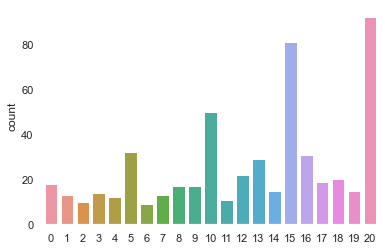

In [101]:
import seaborn as sns

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

sns.countplot(x=pred[:,0].flatten().numpy())

In [8]:
# pred, proba = model.predict_one(train_data_[0])

In [102]:
train_data_[0]['u']

tensor([[[0.0000, 0.5580],
         [0.0667, 0.5391],
         [0.1333, 0.6328],
         [0.2000, 0.5547],
         [0.2667, 0.5547],
         [0.3333, 0.5156],
         [0.4000, 0.5156],
         [0.4667, 0.7500],
         [0.0000, 0.5000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]]])

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

<AxesSubplot:ylabel='count'>

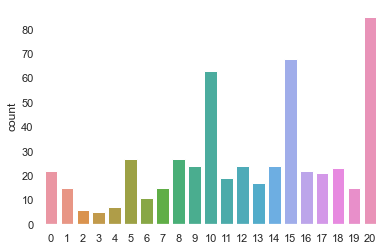

In [118]:
model.save(model_path)
model2 = AH_MODELS[model_name].load(model_path)
pred, proba = model2.predict(train_data_)
sns.countplot(x=pred[:,0].flatten().numpy())

<AxesSubplot:ylabel='count'>

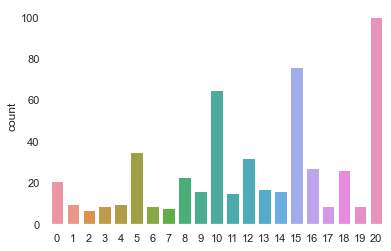

In [119]:
pred, proba = model.predict(train_data_)
sns.countplot(x=pred[:,0].flatten().numpy())

In [109]:
model_path

'../../data/training/ah_10/data/model.pt'

In [108]:
import pickle
with open('../../tmp.pickle', "wb") as output_file:
    pickle.dump(train_data_, output_file)